# Bay wheels EDA 

This is a preliminary exploratory data analysis of Bay Wheels bike sharing sysmtem in San Francisco

In [32]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

In [79]:
#Load data
df = pd.read_csv('BayWheels_data/201810-fordgobike-tripdata.csv', parse_dates = ['start_time', 'end_time'])

In [80]:
df['day']=df['start_time'].dt.day
df['dayofweek']=df['start_time'].dt.dayofweek
df['hour'] = df['start_time'].dt.hour
df = df[df.dayofweek<5]

In [4]:
df['time_cat'] = pd.cut(df.hour, bins = [-1, 5,9,14,18,24], labels = [0,1,2,3,4]).astype(int)

In [6]:
a = df.groupby(['day', 'time_cat']).agg({'bike_id':'count'})
b = a.reset_index().pivot(index = 'day', columns = 'time_cat', values = 'bike_id')
b.columns = ['0 - 5', '5- 9', '9 - 14', '14 - 18', '18 - 24']

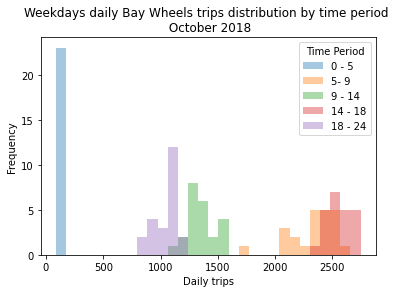

In [9]:
b.plot.hist(bins = 30, alpha = 0.4 )
plt.title('Weekdays daily Bay Wheels trips distribution by time period \n October 2018')
plt.xlabel('Daily trips')
plt.ylabel('Frequency')
plt.legend(title = 'Time Period');

In [24]:
a = df[df['duration_sec'] < 6000]['duration_sec']/60

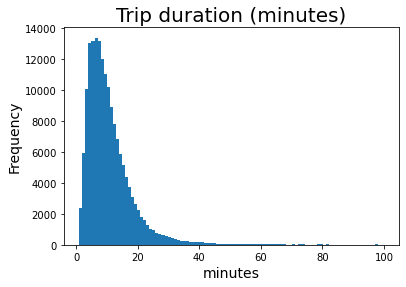

In [28]:
a.plot.hist(bins = 100)
plt.title('Trip duration (minutes)', fontsize = 20)
plt.xlabel('minutes', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14);

## Origins trips

In [147]:
taz = gpd.read_file('taz_shapefiles/Transportation_Analysis_Zones.shp')

In [150]:
df.columns

Index(['duration_sec', 'start_time', 'end_time', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type',
       'bike_share_for_all_trip', 'day', 'dayofweek', 'hour', 'geometry'],
      dtype='object')

In [151]:
#Origin
geo_df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.start_station_longitude, df.start_station_latitude), 
                          crs = 'EPSG:4326')
merged = gpd.sjoin(geo_df, taz, how = 'left', op = 'intersects')
summ = merged.groupby(['taz1454', 'day']).agg({'duration_sec':'count'})
org = summ.reset_index().groupby('taz1454').agg({'duration_sec':'mean'})
org.columns = ['avg_origin']
org.reset_index(inplace = True)


#Destination 
geo_df = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.end_station_longitude, df.end_station_latitude), 
                          crs = 'EPSG:4326')
merged = gpd.sjoin(geo_df, taz, how = 'left', op = 'intersects')
summ = merged.groupby(['taz1454', 'day']).agg({'duration_sec':'count'})
dest = summ.reset_index().groupby('taz1454').agg({'duration_sec':'mean'})
dest.columns = ['avg_dest']
dest.reset_index(inplace = True)

final_v2 = taz.merge(org, how = 'left', on = 'taz1454').merge(dest, how = 'left', on = 'taz1454')
final_v2['avg_origin'] = final_v2['avg_origin'].fillna(-200)
final_v2['avg_dest'] = final_v2['avg_dest'].fillna(-200)

In [152]:
final_v2

,objectid,taz1454,district,county,gacres,Shape__Are,Shape__Len,geometry,avg_origin,avg_dest
0,1,566,11,Santa Clara,1708.683056,0.000444,0.097550,"POLYGON ((-121.86806 37.28720, -121.86888 37.2...",-200.0,-200.0
1,2,565,11,Santa Clara,486.200669,0.000126,0.054171,"POLYGON ((-121.85877 37.28024, -121.85757 37.2...",-200.0,-200.0
2,3,573,11,Santa Clara,538.069933,0.000140,0.057053,"POLYGON ((-121.81238 37.28889, -121.81298 37.2...",-200.0,-200.0
3,4,571,11,Santa Clara,450.407906,0.000117,0.052042,"POLYGON ((-121.80597 37.27730, -121.80847 37.2...",-200.0,-200.0
4,5,576,11,Santa Clara,423.273023,0.000110,0.043438,"POLYGON ((-121.82788 37.30855, -121.82848 37.3...",-200.0,-200.0
...,...,...,...,...,...,...,...,...,...,...
1449,1450,682,13,Santa Clara,767.051202,0.000199,0.060166,"POLYGON ((-121.87739 37.26604, -121.87738 37.2...",-200.0,-200.0
1450,1451,563,11,Santa Clara,2534.162620,0.000658,0.133652,"POLYGON ((-121.84418 37.31045, -121.84450 37.3...",-200.0,-200.0
1451,1452,578,11,Santa Clara,424.406441,0.000110,0.058331,"POLYGON ((-121.85490 37.32734, -121.85508 37.3...",-200.0,-200.0
1452,1453,580,11,Santa Clara,318.280510,0.000083,0.044615,"POLYGON ((-121.84888 37.32775, -121.84928 37.3...",-200.0,-200.0


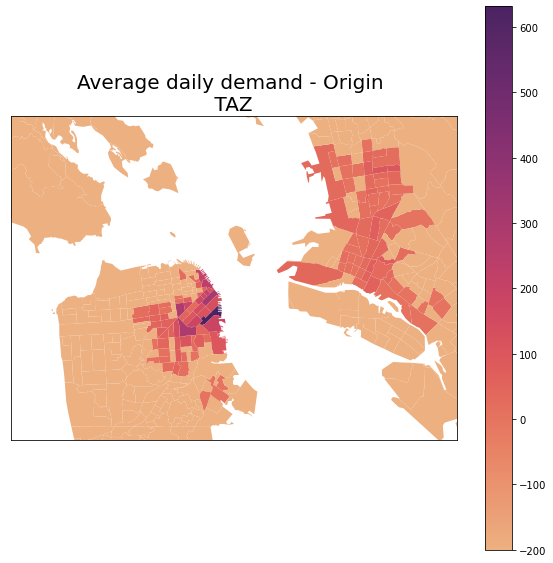

In [163]:
x_min = -122.55
x_max = -122.2 #-121.8
y_min = 37.7 #37.25
y_max = 37.9

# final_v2.plot(column = 'avg_origin', figsize = (20,20), )

fig, ax = plt.subplots(figsize = (10,10))
    
base = final_v2.plot(column = 'avg_origin',  figsize = (10,10), cmap = 'flare', ax = ax, legend = True)

ax.set_ylim([y_min, y_max])
ax.set_xlim([x_min, x_max])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title('Average daily demand - Origin', fontsize = 20);

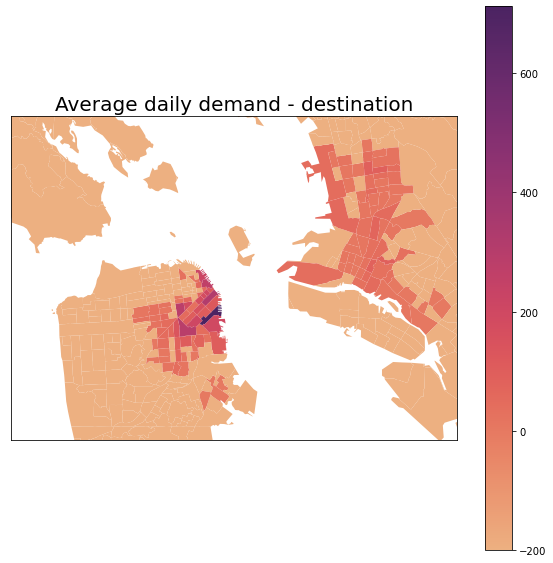

In [159]:
x_min = -122.55
x_max = -122.2 #-121.8
y_min = 37.7 #37.25
y_max = 37.9

# final_v2.plot(column = 'avg_origin', figsize = (20,20), )

fig, ax = plt.subplots(figsize = (10,10))
    
base = final_v2.plot(column = 'avg_dest',  figsize = (10,10), cmap = 'flare', ax = ax, legend = True)

ax.set_ylim([y_min, y_max])
ax.set_xlim([x_min, x_max])
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_title('Average daily demand - destination', fontsize = 20);